# Comparing results from different levels of theory

This tutorial shows how to compare results from different levels of theory, including CREST, CENSO, and single-point DFT calculations on CREST geometries.

- To get started, make sure that the GEOM repo is in your path
- You'll also need to install the [Neural Force Field repository](https://github.com/learningmatter-mit/NeuralForceField) and put it in your path. We'll be using it to rapidly compare distances between conformers using batching with PyTorch

**Note: this tutorial uses the latest GEOM data generated for the MoleculeNet dataset, using both CREST and CENSO. This data will soon be released publicly.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Change to your path for the GEOM repo 

import sys
sys.path.insert(0, '/home/saxelrod/Repo/projects/geom')

# Change to your Neural Force Field path

sys.path.insert(0, '/home/saxelrod/Repo/projects/master/NeuralForceField')



### Loading the CREST and CENSO data

In [3]:
from utils.compare import (load_pickle, get_all_distances, 
                           plot_geometry_changes, get_en_changes,
                           plot_en_changes,
                           plot_energy_comparison, plot_free_en_comparison)
import os

In [4]:

# change to your folders for the saved conformer data

base_dir = '/home/saxelrod/rgb_nfs/GEOM/data_after_reviews'
crest_dir = os.path.join(base_dir, 'bace_water/rd_mols')
censo_dir = os.path.join(base_dir, 'censo/rd_mols')

Load the conformer information for both CREST and CENSO:

In [5]:
censo_dict = load_pickle(censo_dir)
crest_dict = load_pickle(crest_dir)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1511/1511 [08:49<00:00,  2.86it/s]


### Geometry changes
Here we'll look at changes in conformer geometries when going from CREST to CENSO. We'll do this in two ways. The first way is just to look at the CREST conformer that was optimized, and see how much the geometry changed with CENSO. The second is to find the closest CREST conformer to each CENSO conformer, and then see how different they are. The second approach requires a lot of distance calculations, and so it's a bit slow.

In [6]:
out = get_all_distances(crest_dict,
                        censo_dict)

# `output_dic` contains distance information, while the last two outputs
# provide the index mapping between censo conformers and their seed conformers
# in crest (`censo_to_seed_crest`), or censo conformers and the closest
# conformer in crest (`censo_to_closest_crest`)

output_dic, censo_to_seed_crest, censo_to_closest_crest = out

Failed for smiles COc1ccc(C2(c3cccc(-c4cccnc4)c3)CC(OC)C(N)=N2)cc1 with error 'list index out of range'


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1226/1226 [06:20<00:00,  3.22it/s]


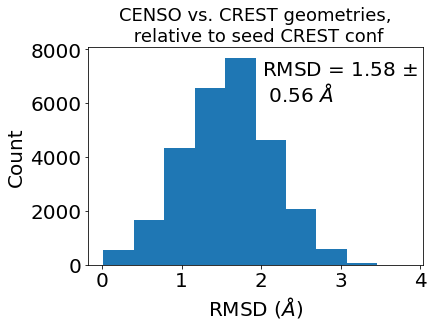

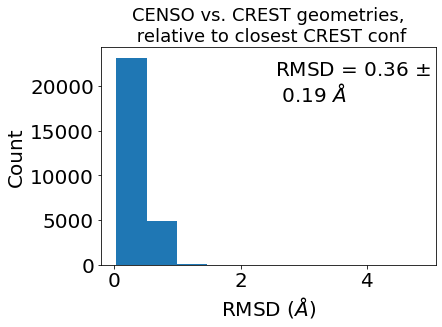

In [7]:
plot_geometry_changes(output_dic)

### Energy ranking changes
#### CREST vs. CENSO

Now we'll look at how the energetic ranking of each conformer changes. We'll plot the distribution of Spearman rank correlation coefficients $\rho$. Each $\rho$ data point measures the correlation between the energetic ranking of CREST conformers and the energetic ranking of CENSO conformers, for a given species. 

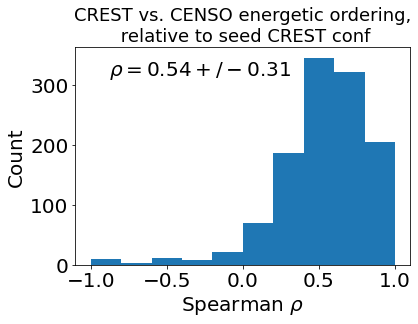

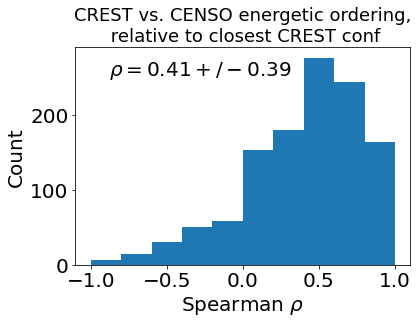

In [11]:
en_results = get_en_changes(censo_dict,
                                crest_dict,
                                censo_to_seed_crest,
                                censo_to_closest_crest)

plot_en_changes(en_results)

#### CENSO vs. single-point 
Next we'll compare the energetic orderings from a CENSO calculation with the single-point energies calculated for CREST goeometries. Single-point DFT calculations are contained in `censo_dict`, so we don't have to load any more information. All we need to do is call `plot_energy_comparison` and tell it the name of the DFT method for comparison (in our case `r2scan_3c_mtzvpp`):

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:00<00:00, 16547.71it/s]


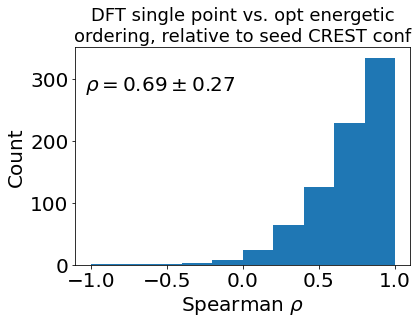

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:03<00:00, 314.43it/s]


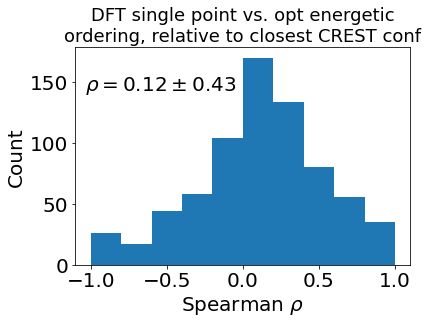

In [12]:
plot_energy_comparison(crest_dict,
                       censo_dict,
                       censo_to_closest_crest,
                       dft_name='r2scan_3c_mtzvpp')


### Energy vs. free energy
Lastly, let's compare the orderings based on CENSO energies to those based on CENSO free energies (which incorporate translational, rotational, and vibrational entropy, plus zero-point vibrational corrections).

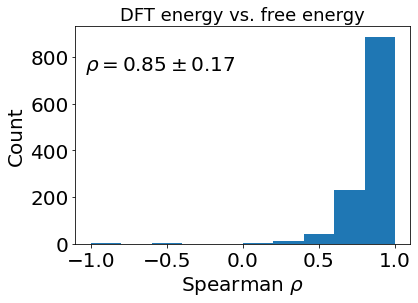

In [13]:
plot_free_en_comparison(censo_dict)